In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns
import pingouin as pg
from tqdm import tqdm

from src import data, paths, matrix_filtering
from scipy import signal
import warnings

from sklearn import metrics as sk_metrics
from matplotlib.colors import LinearSegmentedColormap

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

plt.style.use('ggplot')
%matplotlib inline

!date -I

2024-05-09


In [2]:
graph_density = 0.25

In [3]:
def plot_data(data,title=None,stimulation_time=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data)
    if stimulation_time:
        plt.axvline(stimulation_time, ymin=np.min(data), ymax=np.max(data),ls=":",label="stimulation time")
    plt.title(title)
    plt.show()

def plot_one_roi(data,roi_id,labels,title=None,constants_h=[],constants_v=[]):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data[:,roi_id])
    for c in constants_h:
        plt.plot([c]*data.shape[0],color="k")
    for c in constants_v:
        plt.vlines(c, np.min(data), np.max(data),color="k")
    plt.title(labels[roi_id])
    plt.show()

## Settings

In [4]:
response_length = 200

## Load data

### Load pytepfit data

In [5]:
empirical_or_simulated = 'empirical'
pytepfit_path = 'external/pytepfit/'
data_pytepfit = np.load(paths.path(f'{pytepfit_path}source_estimates/{empirical_or_simulated}.npz'))
data_pytepfit['ts'].shape

(400, 200)

In [6]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [7]:
stimulation_time = 100

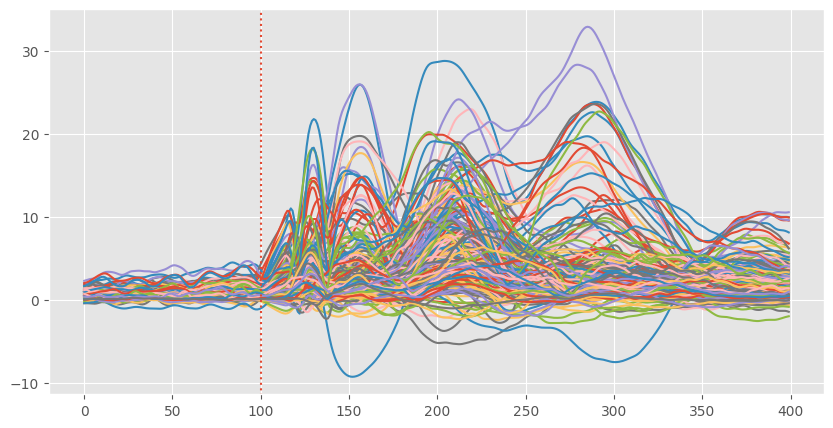

In [8]:
data_ts = data_pytepfit['ts']
plot_data(data_ts,stimulation_time=stimulation_time)

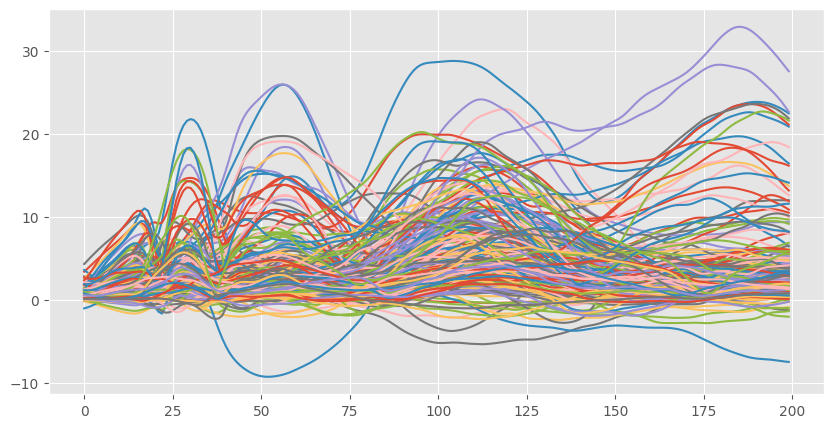

In [9]:
data_ts_croped = data_ts[stimulation_time:stimulation_time+response_length,:]
plot_data(data_ts_croped)

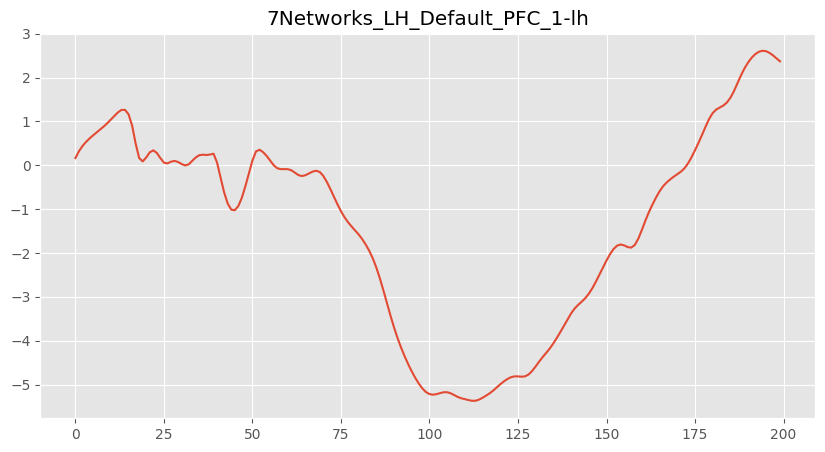

In [10]:
plot_one_roi(data_ts_croped,17,data_pytepfit['labels'])

In [11]:
def peak_analysis(sequence,threshold):
    peaks = signal.find_peaks(sequence,height=threshold)
    if len(peaks[0]) == 0:
        return np.nan, np.nan, np.nan, np.nan

    first_peak_time = peaks[0][0]
    first_peak_height = peaks[1]['peak_heights'][0]
    max_peak_time = peaks[0][np.argmax(peaks[1]['peak_heights'])]
    max_peak_height = np.max(peaks[1]['peak_heights'])

    return first_peak_time, first_peak_height, max_peak_time, max_peak_height

def estimate_auc(seqence, threshold):
    estimate = 0

    for v in seqence:
        if v > threshold:
            estimate += v

    if estimate > 0:
        return estimate

    return None
    

def get_threshold_range(data,stim_idx):
    maxima = np.max(data[stim_idx:,:],axis=0)
    print(maxima.shape)
    maxima.sort()

    upper = int(maxima[-30]) # for higest threshold there should be at least 30 responses above for statistics
    lower = int(np.max(data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    return range(lower, upper, step)

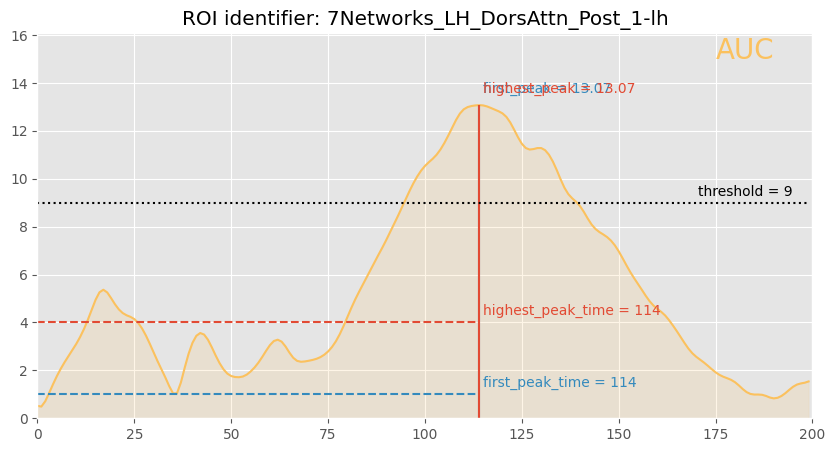

In [16]:
colors=['#E24A33', '#348ABD', '#8EBA42', '#777777','#FBC15E', '#FFB5B8', '#988ED5']

def plot_one_roi_response_definitions(data,roi_id,labels,thr):
    plt.rcParams['figure.figsize'] = [10, 5]
    selected_curve = data[:,roi_id]

    amp_id, amp, amp_h_id, amp_h = peak_analysis(selected_curve,threshold=thr)

    auc_color = colors[4]
    first_peak_color = colors[1]
    highest_peak_color = colors[0]

    plt.figure()

    plt.plot(data[:,roi_id],color=auc_color)
    plt.fill_between([i for i in range(len(selected_curve))],selected_curve,alpha=0.15,color=auc_color)
    plt.text(175, 15, "AUC",color=auc_color,fontsize=20)

    plt.vlines(amp_id, 0, amp,color=first_peak_color)
    plt.text(amp_id+1, amp+0.5, f"first_peak = {amp:.2f}",color=first_peak_color)
    plt.plot([1]*(amp_id+1),color=first_peak_color,ls="--")
    plt.text(amp_id+1, 1+0.3, f"first_peak_time = {amp_id}",color=first_peak_color)

    plt.vlines(amp_h_id, 0, amp_h,color=highest_peak_color)
    plt.text(amp_h_id+1, amp_h+0.5, f"highest_peak = {amp_h:.2f}",color=highest_peak_color)
    plt.plot([4]*(amp_h_id+1),color=highest_peak_color,ls="--")
    plt.text(amp_h_id+1, 4+0.3, f"highest_peak_time = {amp_h_id}",color=highest_peak_color)

    ax = plt.gca()
    ax.set_ylim([0,amp_h+3])
    ax.set_xlim([0, len(selected_curve)])

    
    plt.title(f"ROI identifier: {labels[roi_id]}")
    plt.plot([thr]*len(selected_curve),color="k",ls=":")
    plt.text(len(selected_curve)-5, thr+0.3, f"threshold = {thr}",color='k',horizontalalignment='right')
    

    plt.show()

plot_one_roi_response_definitions(data_ts_croped,42,labels=data_pytepfit['labels'],thr=9)

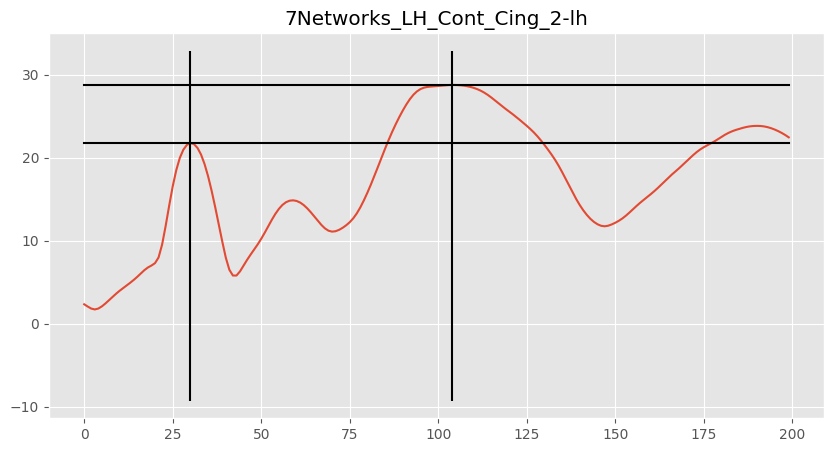

In [17]:
roi_idx = 1

amp_id, amp, amp_h_id, amp_h = peak_analysis(data_ts_croped[:,roi_idx],threshold=8)

plot_one_roi(data_ts_croped,roi_idx,labels=data_pytepfit['labels'],constants_h=[amp,amp_h],constants_v=[amp_id,amp_h_id])

In [18]:
responses = {} 
stim_time = 100

df_responses = pd.DataFrame()

thr_range = get_threshold_range(data_ts,stim_time)
list_of_thresholds = []


# sklearn.metrics.auc(x, y)

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200))

    response_df['01-response'] =  np.where(np.max(data_ts_croped,axis=0) > threshold,1,0)

    peak_analysis_results = np.zeros((200,4),dtype=float)
    for i in range(200):
        peak_analysis_results[i] = peak_analysis(data_ts_croped[:,i],threshold)

    response_df['first_peak'] = peak_analysis_results[:,0]
    response_df['first_peak_time'] = peak_analysis_results[:,1]
    response_df['highest_peak'] = peak_analysis_results[:,2]
    response_df['highest_peak_time'] = peak_analysis_results[:,3]

    response_df['variance'] = np.var(data_ts_croped,axis=0)
    response_df['diff'] = np.max(data_ts_croped,axis=0)-np.min(data_ts_croped,axis=0)

    response_df['AUC'] = np.array([sk_metrics.auc(list(range(len(data_ts_croped[:,i]))), data_ts_croped[:,i]) for i in range(200)],dtype=float)
    response_df['AUC_curve_above_thr'] = np.array([sk_metrics.auc(list(range(len(data_ts_croped[:,i]))), (data_ts_croped[:,i]-threshold).clip(min=0)) for i in range(200)],dtype=float)
    response_df['mean'] = np.array([np.mean(data_ts_croped[:,i]) for i in range(200)],dtype=float)
    response_df['power'] = np.array([np.sum(data_ts_croped[:,i]**2) for i in range(200)],dtype=float)

    for c in ['variance','diff','AUC','AUC_curve_above_thr','mean','power']:
        response_df[c] = np.where(response_df['01-response'],response_df[c],np.nan)

    responses[threshold] = response_df
    list_of_thresholds.append(threshold)

(200,)


In [19]:
def prepare_barcode(n_rows,n_cols,title=None):
    pixel_per_bar = 6
    dpi = 100

    fig, ax = plt.subplots(n_rows, 1, figsize=(n_cols * pixel_per_bar / dpi, n_rows/1.5), dpi=dpi, sharex=True)
    fig.suptitle(title)
    fig.subplots_adjust(right=0.7)

    return fig, ax

def plot_one_barcode(ax,data,title=None):

    if not isinstance(data, np.ndarray):
        code = data.to_numpy().reshape(1,-1).astype(float)
    else:
        code = data.reshape(1,-1).astype(float)

    code = np.nan_to_num(code)

    ax.imshow(code, cmap='binary', aspect='auto',
          interpolation='nearest')
    ax.set_title(f"  {title}", loc="right", y=0, ha="left", va="center")
    ax.set_yticks([])

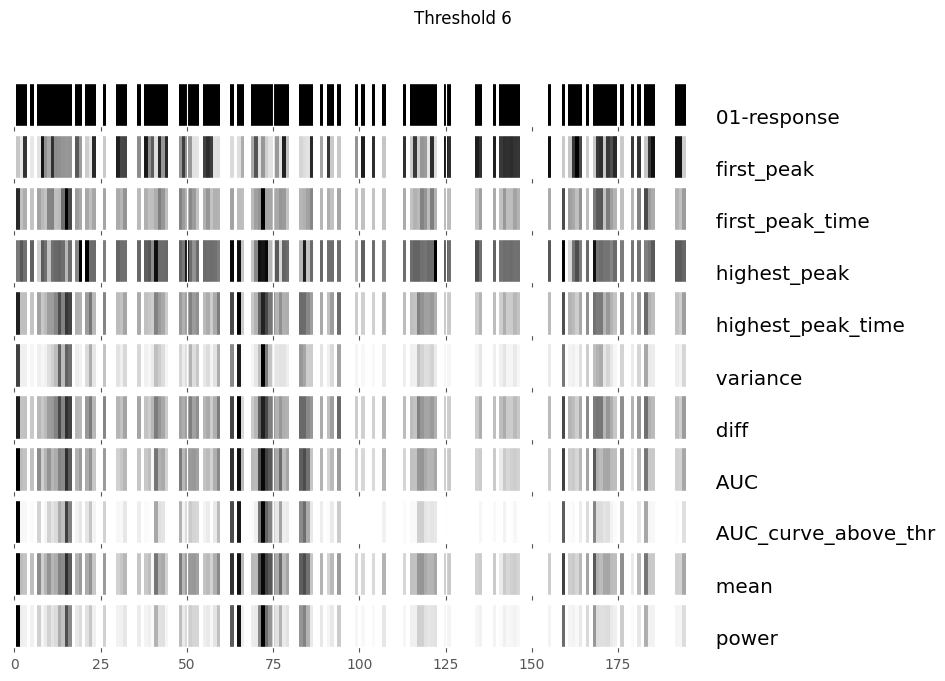

In [20]:
thr = list_of_thresholds[2]

fig, axs = prepare_barcode(len(responses[thr].columns),200,title=f"Threshold {thr}")

for i,c in enumerate(responses[thr].columns):
    plot_one_barcode(axs[i],responses[thr][c],title=c)

In [21]:
def heatmap(x, y, r, p, ax, size,thr):
    
    # Mapping from column names to integer coordinates
    x_labels = x.unique()#[v for v in sorted(x.unique())]
    y_labels = x.unique()#[v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    color = np.where(p<0.05,r,0)
    
    sns.scatterplot(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s= size**2 * 6000,
        hue=color,
        marker='o',
        ax=ax,
        palette=sns.color_palette("seismic", as_cmap=True),
        linewidth=0
    )

    # Show column labels on the axes
    ax.set_xlim(left=-1,right=len(x_labels))
    ax.set_ylim(bottom=-1,top=len(x_labels))
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels) 

    sns.scatterplot(
        x=[7],
        y=[1],
        s= ((size*4)**2 * 6000),
        c="darkgray",
        marker='o',
        ax=ax,
        linewidth=1
    )
    shift = (size-0.1)*1.9
    ax.text(x=7-shift, y=1, s=thr,color='white',fontsize=10,verticalalignment='center',horizontalalignment='right')

In [22]:
if False:
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(16,15))
    fig.suptitle("Correlations between various definitons of response intensity\nfor 10 different thresholds in cocentric circles")
    plot_grid = plt.GridSpec(1, 16, hspace=0.2, wspace=0.1,figure=fig) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1])
    #fig, ax = plt.subplots(figsize=(15,15))

    num_of_thr_values = len(responses.keys())

    for i,k in enumerate(responses.keys()):

        s=1-i/num_of_thr_values
        df_corr = pg.pairwise_corr(responses[k].loc[:, responses[k].columns != '01-response'],method='spearman')
        #df_corr["sigf"] = df_corr["p-unc"].apply(lambda x: "*" if x < 0.05 else "")
        #display(df_corr)
        heatmap(df_corr['X'],df_corr['Y'],df_corr['r'],df_corr['p-unc'],ax=ax,size=s,thr=k)

    ax.get_legend().remove()
    ax.text(x=7, y=3, s="Thresholds",color='black',fontsize=12,verticalalignment='center',horizontalalignment='center')
    ax.set(xlabel=None)
    ax.set(ylabel=None)

    ax_bar = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    n_colors = 256
    col_x = [0]*n_colors # Fixed x coordinate for the bars
    bar_y=np.linspace(-1,1, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax_bar.barh(
        y=bar_y,
        width=[5]*n_colors, # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=sns.color_palette("seismic", n_colors=n_colors), # Create the palette,
        linewidth=0
    )
    ax_bar.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax_bar.grid(False) # Hide grid
    ax_bar.set_xticks([]) # Remove horizontal ticks
    ax_bar.yaxis.tick_right()
    ax_bar.set_yticks(np.linspace(min(bar_y), max(bar_y), 9)) # Show vertical ticks for min, middle and max


    plt.show()

In [23]:
stim_locatin = 85 # FIXME

### Load structural (and functional) connectivity data

In [24]:
SC_matrices = data.load_set_of_schaefer_matrices_for_pytepfit()

SC_matrices_filtered = []

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data
    pivot = matrix_filtering.find_pivot_to_keep_xpercent_edges(SC_W,graph_density)
    SC_W = np.where(SC_W>=pivot,SC_W,0)
    if SC_L is not None:
        SC_L = np.where(SC_W>=pivot,SC_L,np.nan)
    SC_W_log = np.where(SC_W>=pivot,SC_W_log,np.nan)
    SC_matrices_filtered.append((name, SC_W, SC_L, SC_W_log))

SC_matrices = SC_matrices_filtered

/home/katterrina/fi_muni/0_diplomka/src/data.py:130: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append(("PyTepFit_simple",SC_W_pytep, SC_L_pytep,np.log(SC_W_pytep)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


load domhof
load domhof
load domhof


In [25]:
centroids_file = paths.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')
centroids_mne = data.get_centroids_from_file(centroids_file,"geom_mne")

ED = data.roi_distances_from_centroids(centroids_mne)

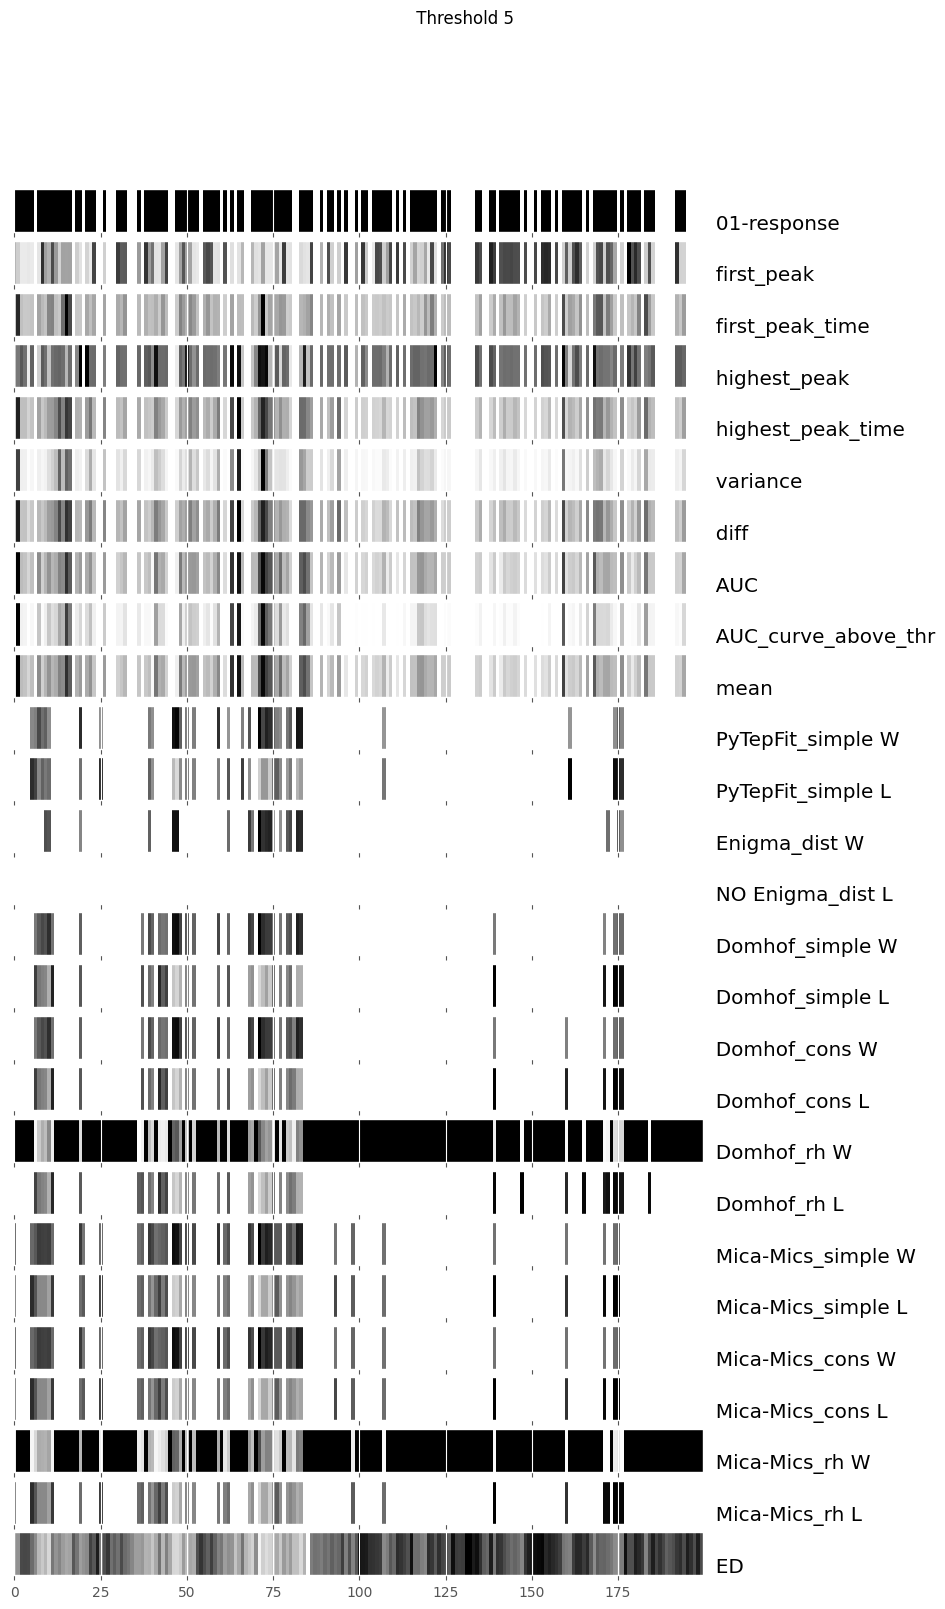

In [26]:
thr = list_of_thresholds[1]
n_of_response_def = len(responses[thr].columns)

fig, axs = prepare_barcode(n_of_response_def+2*len(SC_matrices),200, title = f" Threshold {thr}")

for i,c in enumerate(responses[thr].columns):
    plot_one_barcode(axs[i],responses[thr][c],title=c)

for j,d in enumerate(SC_matrices):
    name, SC_W,SC_L,SC_W_log = d
    plot_one_barcode(axs[i+2*j],SC_W_log[stim_locatin],title=f"{name} W")
    if SC_L is not None:
        plot_one_barcode(axs[i+2*j+1],SC_L[stim_locatin],title=f"{name} L")
    else:
        z = np.zeros(SC_W_log[stim_locatin].shape)
        plot_one_barcode(axs[i+2*j+1],z,title=f"NO {name} L")

plot_one_barcode(axs[-1],ED[stim_locatin],title=f"ED")

In [27]:
all_responses = pd.concat(responses)
all_responses

01-response  first_peak  first_peak_time  highest_peak  \
4  0              1        47.0         5.816432          47.0   
   1              1        30.0        21.778551         104.0   
   2              1        13.0         6.474365         128.0   
   3              1        13.0         5.517997         109.0   
   4              1        15.0         5.643366          15.0   
...             ...         ...              ...           ...   
13 195            0         NaN              NaN           NaN   
   196            0         NaN              NaN           NaN   
   197            0         NaN              NaN           NaN   
   198            0         NaN              NaN           NaN   
   199            0         NaN              NaN           NaN   

        highest_peak_time   variance       diff          AUC  \
4  0             5.816432   3.123393   6.224032   253.332072   
   1            28.793386  55.774696  27.077971  3429.233902   
   2             8.258207   4.778983   7.251653   899.571678   
   3             8.355309   4.468710   7.336567   795.702728   
   4             5.643366   0.600524   4.283547   560.813191   
...                   ...        ...        ...          ...   
13 195                NaN        NaN        NaN          NaN   
   196                NaN        NaN        NaN          NaN   
   197                NaN        NaN        NaN          NaN   
   198                NaN        NaN        NaN          NaN   
   199                NaN        NaN        NaN          NaN   

        AUC_curve_above_thr       mean         power  
4  0              18.783715   1.280818    952.777344  
   1            2648.501212  17.208191  70379.312500  
   2             241.025893   4.514212   5031.417969  
   3             169.231327   3.990539   4078.622070  
   4              10.066674   2.813737   1703.527832  
...                     ...        ...           ...  
13 195                  NaN        NaN           NaN  
   196                  NaN        NaN           NaN  
   197                  NaN        NaN           NaN  
   198                  NaN        NaN           NaN  
   199                  NaN        NaN           NaN  

[2000 rows x 11 columns]

## First attempt with only one selected SC matrix

Select Mica-Mics structural with RH preprocessing, because we already know that it results into correlations for F-Tract.

In [30]:
for i, m in enumerate(SC_matrices):
    print(i, m[0])

0 PyTepFit_simple
1 Enigma_dist
2 Domhof_simple
3 Domhof_cons
4 Domhof_rh
5 Mica-Mics_simple
6 Mica-Mics_cons
7 Mica-Mics_rh


In [31]:
name, SC_W, SC_L, _ = SC_matrices[7]

## Correlations

In [32]:
def select_response_by_definition(definition,rdict):
    new_df = pd.DataFrame()
    for thr in rdict.keys():
        new_df[f"{thr:02d}"] = rdict[thr][definition]
    
    return new_df  

In [33]:
def plot_df_as_heatmap(df,x_axis,y_axis,value,x_label="threshold",y_label="",p=None,title=None,ax=None):
    pivot = df.pivot(index=x_axis, columns=y_axis, values=value)
    if p is not None:
        pivot_p = df.pivot(index=x_axis, columns=y_axis, values=p)
        pivot = pivot.where(pivot_p < 0.05)

    cmap = LinearSegmentedColormap.from_list('', ['#FF2200', 'white', '#FF2200'])# 'seismic'

    if ax is not None:
        sns.heatmap(pivot, annot=True,center=0,cmap=cmap,vmin=-1, vmax=1,ax=ax)
    else:
        ax = sns.heatmap(pivot, annot=True,center=0,cmap=cmap,vmin=-1, vmax=1,ax=ax)
    ax.set_title(title)
    ax.set(xlabel=x_label)
    ax.set(ylabel=y_label)


def create_metrics_dataframe(ED,SC_W,SC_L,stim_locatin,dataframe_to_extend=None):
    if dataframe_to_extend is not None:
        communication_metrics_dataset = dataframe_to_extend.copy()
    else:
        communication_metrics_dataset = pd.DataFrame()
    
    communication_metrics_dataset["ED"] = pd.Series(ED[stim_locatin])
    communication_metrics_dataset["SC_W"] = pd.Series(SC_W[stim_locatin])
    communication_metrics_dataset["SC_L"] = pd.Series(SC_L[stim_locatin])

    SC_W_log = np.log(SC_W)
    communication_metrics_dataset["SC_W_log"] = pd.Series(SC_W_log[stim_locatin])

    # shortest path efficiency
    shorest_paths,_ = metrics.distance_wei_floyd(SC_L)
    shorest_path_eff = np.divide(1,shorest_paths) 
    # warning because of 0 diagonal, fill diagonal with nans
    np.fill_diagonal(shorest_path_eff,np.nan)
    communication_metrics_dataset["shorest_path_eff"] = pd.Series(shorest_path_eff[stim_locatin])
    
    # communicability
    com = metrics.communicability_wei(np.nan_to_num(SC_W))
    communication_metrics_dataset["communicability"] = pd.Series(com[stim_locatin])
    
    # search information
    SI = metrics.search_information(np.nan_to_num(SC_W),SC_L)
    communication_metrics_dataset["SI"] = pd.Series(SI[stim_locatin])
    
    glob_diffusion, diffusion = metrics.diffusion_efficiency(np.nan_to_num(SC_W))
    communication_metrics_dataset["diffusion_eff"] = pd.Series(diffusion[stim_locatin])
    
    # navigation path efficiency
    _,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, np.nan_to_num(SC_W))
    np.fill_diagonal(nav_paths,np.nan)
    nav_eff = np.divide(1,nav_paths)
    communication_metrics_dataset["nav_eff"] = pd.Series(nav_eff[stim_locatin])

    return communication_metrics_dataset

def corr_columns_of_two_matrices(responses_by_threshold,metrics):

    col_names_thresholds = list(responses_by_threshold.keys())
    col_names_SC = list(metrics.keys())
    print(col_names_SC)
    print(col_names_thresholds)

    df = pd.concat([responses_by_threshold,metrics], axis=1, join="inner")
    print(list(df.keys()))

    stat_pg = pg.pairwise_corr(df,columns=[col_names_thresholds,col_names_SC],method="spearman").round(3)

    return stat_pg

In [34]:
df_metrics = create_metrics_dataframe(ED,SC_W,SC_L,stim_locatin)
df_metrics.head(10)

/tmp/ipykernel_42656/767568784.py:28: RuntimeWarning: divide by zero encountered in log
  SC_W_log = np.log(SC_W)
/tmp/ipykernel_42656/767568784.py:33: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:781: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


,ED,SC_W,SC_L,SC_W_log,shorest_path_eff,communicability,SI,diffusion_eff,nav_eff
0,45.307805,0.001481,56.91748,-6.515350,0.017569,0.005899,8.492163,0.004902,0.017569
1,56.289608,0.000000,NaN,-inf,0.012035,0.001445,13.765920,0.003926,0.000000
2,92.766248,0.000000,NaN,-inf,0.008308,0.000284,13.524316,0.002492,0.000000
3,94.172221,0.000000,NaN,-inf,0.008227,0.001046,15.620317,0.004036,0.000000
4,92.564602,0.000000,NaN,-inf,0.008065,0.000696,12.555779,0.003484,0.000000
5,75.104399,0.001224,98.03496,-6.705932,0.010200,0.005410,8.767115,0.004969,0.000000
6,59.889275,0.002677,79.26140,-5.922912,0.012616,0.012717,7.637456,0.004934,0.000000
7,35.839675,0.009072,55.63266,-4.702512,0.017975,0.031510,5.876792,0.005205,0.000000
8,27.989925,0.008208,54.90082,-4.802592,0.018215,0.030197,6.021175,0.005110,0.018215
9,36.892542,0.007547,54.96460,-4.886602,0.018194,0.028358,6.142377,0.004883,0.018194


0it [00:00, ?it/s]

['ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', 'ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']


,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,200,-0.183,"[-0.31, -0.05]",0.009,0.741
1,04,SC_W,spearman,two-sided,200,0.140,"[0.0, 0.27]",0.047,0.511
2,04,SC_L,spearman,two-sided,49,0.181,"[-0.11, 0.44]",0.213,0.240
3,04,SC_W_log,spearman,two-sided,200,0.140,"[0.0, 0.27]",0.047,0.511
4,04,shorest_path_eff,spearman,two-sided,199,0.162,"[0.02, 0.29]",0.022,0.631
5,04,communicability,spearman,two-sided,200,0.160,"[0.02, 0.29]",0.024,0.620
6,04,SI,spearman,two-sided,199,-0.141,"[-0.27, -0.0]",0.047,0.511
7,04,diffusion_eff,spearman,two-sided,200,-0.148,"[-0.28, -0.01]",0.037,0.553
8,04,nav_eff,spearman,two-sided,199,0.084,"[-0.06, 0.22]",0.237,0.220
9,05,ED,spearman,two-sided,200,-0.214,"[-0.34, -0.08]",0.002,0.863


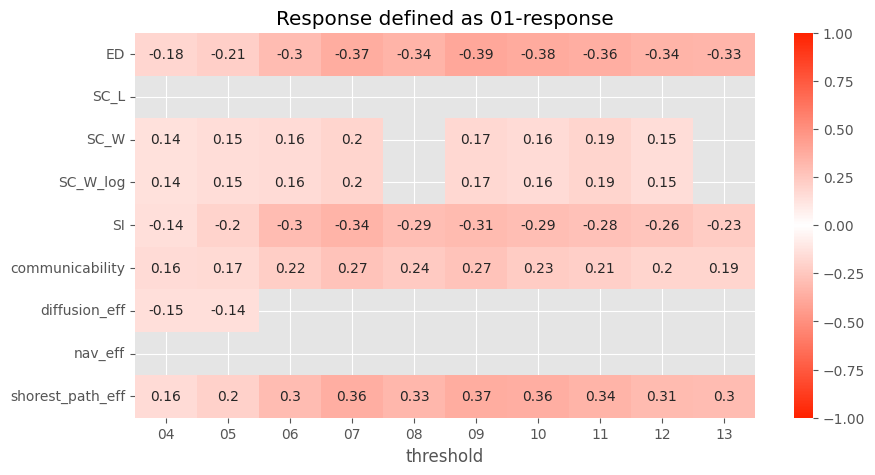

1it [00:00,  1.09it/s]

['ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', 'ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,0.286,"[0.14, 0.42]",0.000,0.955
1,04,SC_W,spearman,two-sided,157,-0.214,"[-0.36, -0.06]",0.007,0.773
2,04,SC_L,spearman,two-sided,44,0.425,"[0.15, 0.64]",0.004,0.834
3,04,SC_W_log,spearman,two-sided,157,-0.214,"[-0.36, -0.06]",0.007,0.773
4,04,shorest_path_eff,spearman,two-sided,156,-0.298,"[-0.43, -0.15]",0.000,0.968
5,04,communicability,spearman,two-sided,157,-0.222,"[-0.37, -0.07]",0.005,0.803
6,04,SI,spearman,two-sided,156,0.288,"[0.14, 0.43]",0.000,0.957
7,04,diffusion_eff,spearman,two-sided,157,-0.063,"[-0.22, 0.09]",0.436,0.122
8,04,nav_eff,spearman,two-sided,156,-0.086,"[-0.24, 0.07]",0.285,0.188
9,05,ED,spearman,two-sided,133,0.382,"[0.23, 0.52]",0.000,0.996


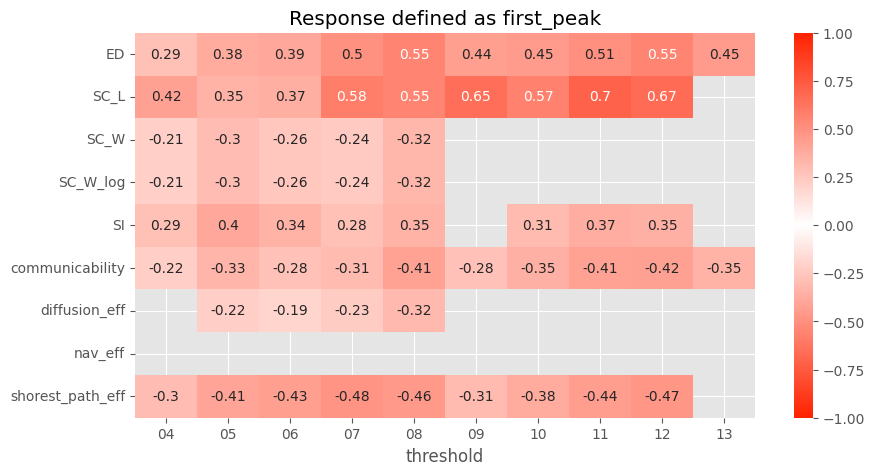

2it [00:01,  1.07it/s]

['ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', 'ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.283,"[-0.42, -0.13]",0.000,0.952
1,04,SC_W,spearman,two-sided,157,0.158,"[0.0, 0.31]",0.049,0.507
2,04,SC_L,spearman,two-sided,44,-0.054,"[-0.35, 0.25]",0.727,0.064
3,04,SC_W_log,spearman,two-sided,157,0.158,"[0.0, 0.31]",0.049,0.507
4,04,shorest_path_eff,spearman,two-sided,156,0.281,"[0.13, 0.42]",0.000,0.947
5,04,communicability,spearman,two-sided,157,0.219,"[0.06, 0.36]",0.006,0.790
6,04,SI,spearman,two-sided,156,-0.264,"[-0.4, -0.11]",0.001,0.918
7,04,diffusion_eff,spearman,two-sided,157,0.100,"[-0.06, 0.25]",0.212,0.239
8,04,nav_eff,spearman,two-sided,156,-0.092,"[-0.25, 0.07]",0.251,0.210
9,05,ED,spearman,two-sided,133,-0.268,"[-0.42, -0.1]",0.002,0.882


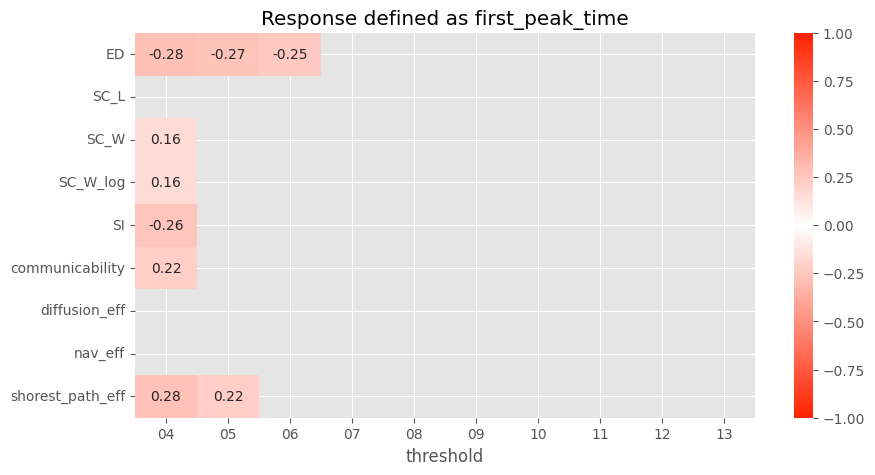

3it [00:02,  1.05it/s]

['ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', 'ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,0.121,"[-0.04, 0.27]",0.131,0.329
1,04,SC_W,spearman,two-sided,157,-0.106,"[-0.26, 0.05]",0.187,0.263
2,04,SC_L,spearman,two-sided,44,0.270,"[-0.03, 0.52]",0.077,0.432
3,04,SC_W_log,spearman,two-sided,157,-0.106,"[-0.26, 0.05]",0.187,0.263
4,04,shorest_path_eff,spearman,two-sided,156,-0.132,"[-0.28, 0.03]",0.101,0.377
5,04,communicability,spearman,two-sided,157,-0.150,"[-0.3, 0.01]",0.061,0.468
6,04,SI,spearman,two-sided,156,0.128,"[-0.03, 0.28]",0.112,0.357
7,04,diffusion_eff,spearman,two-sided,157,-0.025,"[-0.18, 0.13]",0.755,0.061
8,04,nav_eff,spearman,two-sided,156,-0.041,"[-0.2, 0.12]",0.615,0.079
9,05,ED,spearman,two-sided,133,0.145,"[-0.03, 0.31]",0.097,0.384


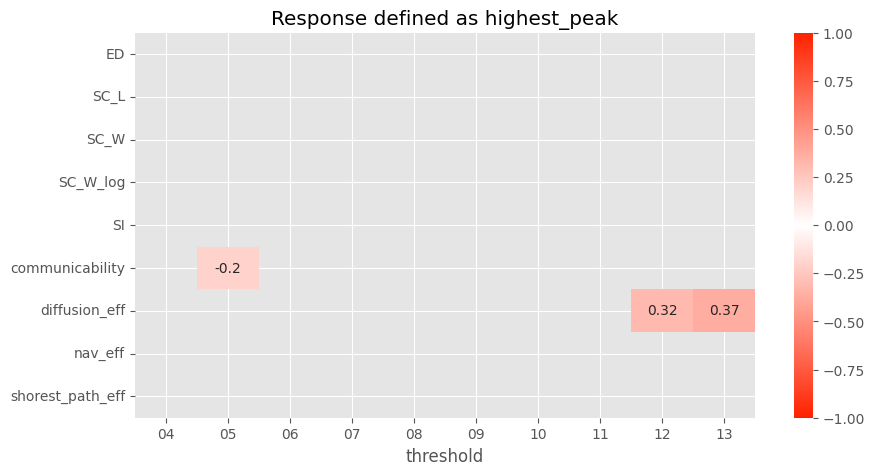

4it [00:03,  1.17it/s]

['ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13']
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', 'ED', 'SC_W', 'SC_L', 'SC_W_log', 'shorest_path_eff', 'communicability', 'SI', 'diffusion_eff', 'nav_eff']


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.456,"[-0.57, -0.32]",0.000,1.000
1,04,SC_W,spearman,two-sided,157,0.226,"[0.07, 0.37]",0.004,0.818
2,04,SC_L,spearman,two-sided,44,-0.353,"[-0.59, -0.06]",0.019,0.664
3,04,SC_W_log,spearman,two-sided,157,0.226,"[0.07, 0.37]",0.004,0.818
4,04,shorest_path_eff,spearman,two-sided,156,0.430,"[0.29, 0.55]",0.000,1.000
5,04,communicability,spearman,two-sided,157,0.321,"[0.17, 0.45]",0.000,0.985
6,04,SI,spearman,two-sided,156,-0.386,"[-0.51, -0.24]",0.000,0.999
7,04,diffusion_eff,spearman,two-sided,157,0.145,"[-0.01, 0.29]",0.071,0.441
8,04,nav_eff,spearman,two-sided,156,0.000,"[-0.16, 0.16]",0.997,0.050
9,05,ED,spearman,two-sided,133,-0.534,"[-0.65, -0.4]",0.000,1.000


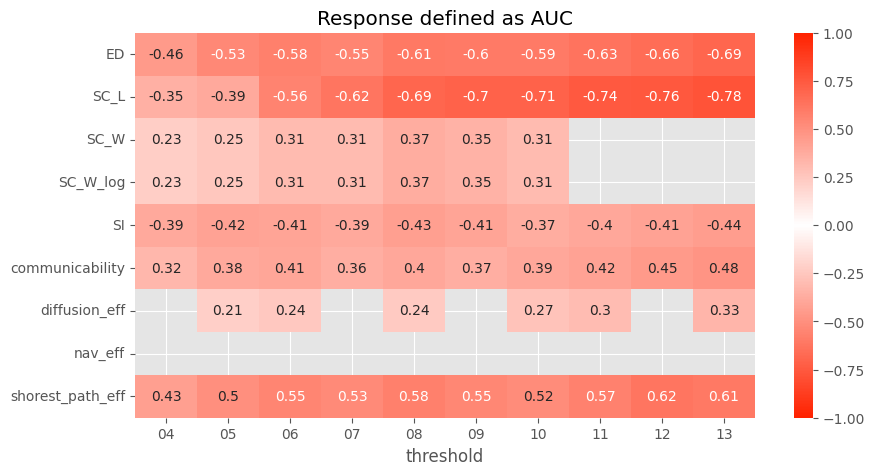

5it [00:04,  1.12it/s]


In [35]:
selected_response_definitions= ['01-response', 'first_peak', 'first_peak_time', 'highest_peak', 'AUC']
pd.set_option('display.max_rows', None)

for i,resp_definition in tqdm(enumerate(selected_response_definitions)):
    responses_df = select_response_by_definition(resp_definition,responses)  
    

    df = corr_columns_of_two_matrices(responses_df,df_metrics)
        
    display(df)

    plt.figure(figsize=(10,5))
    plot_df_as_heatmap(df,"Y","X","r",p="p-unc",title=f"Response defined as {resp_definition}")
    plt.show()